In [ ]:
# === 网络请求与网页解析 ===
import requests
from bs4 import BeautifulSoup
import re
import csv

# === 数据处理与分析 ===
import pandas as pd
import numpy as np
from collections import Counter
from itertools import tee, islice
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import LinearRegression

# === 可视化 ===
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from wordcloud import WordCloud

# === 其他工具 ===
import string

In [2]:
def fix_conference_spacing(name):
    # 修正会议名称中的空格问题
    name = re.sub(r'(\d+(?:st|nd|rd|th))([A-Z])', r'\1 \2', name)
    name = re.sub(r'([A-Za-z])(\d{4})', r'\1 \2', name)
    return name

def get_html(url):
    print(f"正在抓取页面: {url}")
    r = requests.get(url)
    if r.status_code != 200:
        print(f"抓取失败，状态码：{r.status_code}，跳过该页")
        return None
    return r.text

In [3]:
def parse_papers_from_year_page(html, year, conf_name):
    soup = BeautifulSoup(html, 'html.parser')
    results = []

    entries = soup.find_all('li', class_='entry inproceedings')

    for entry in entries:
        title_tag = entry.find('span', class_='title')
        title = title_tag.text.strip() if title_tag else ""

        authors = []
        for author_tag in entry.find_all('span', itemprop='author'):
            name_tag = author_tag.find('span', itemprop='name')
            if name_tag:
                authors.append(name_tag.text.strip())

        conference_name = f"{conf_name.upper()} {year}"
        conference_name = fix_conference_spacing(conference_name)

        link_tag = entry.find('a', href=True)
        link = link_tag['href'] if link_tag else ""

        results.append({
            'title': title,
            'authors': authors,
            'year': str(year),
            'conference': conference_name,
            'link': link
        })

    return results

In [4]:
def crawl_conference_years(conf_name, start_year=2020, end_year=2025):
    all_papers = []
    for year in range(end_year, start_year - 1, -1):
        url = f"https://dblp.uni-trier.de/db/conf/{conf_name}/{conf_name}{year}.html"
        html = get_html(url)
        if html:
            papers = parse_papers_from_year_page(html, year, conf_name)
            all_papers.extend(papers)
    return all_papers

In [5]:
# 测试抓取多年份数据
papers_ijcai = crawl_conference_years('ijcai', 2020, 2025)
papers_cvpr = crawl_conference_years('cvpr', 2020, 2025)
papers_aaai = crawl_conference_years('aaai', 2020, 2025)

正在抓取页面: https://dblp.uni-trier.de/db/conf/ijcai/ijcai2025.html
抓取失败，状态码：404，跳过该页
正在抓取页面: https://dblp.uni-trier.de/db/conf/ijcai/ijcai2024.html


KeyboardInterrupt: 

In [ ]:
papers_ijcai[:3]  # 显示前3条

In [ ]:
papers_cvpr[:3]  # 显示前3条

In [ ]:
papers_aaai[:3]  # 显示前3条

In [6]:
def save_papers_to_csv(papers, filename="papers.csv"):
    # 定义 CSV 文件的字段名（列名）
    fieldnames = ['title', 'authors', 'year', 'conference', 'link']

    with open(filename, mode='w', encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)

        # 写入表头
        writer.writeheader()

        for paper in papers:
            # authors 列是列表，转成用分号分隔的字符串
            paper['authors'] = '; '.join(paper['authors'])
            writer.writerow(paper)

    print(f"成功保存 {len(papers)} 篇论文到文件：{filename}")

In [7]:
save_papers_to_csv(papers_ijcai, "ijcai_papers_2020_2025.csv")
save_papers_to_csv(papers_cvpr, "cvpr_papers_2020_2025.csv")
save_papers_to_csv(papers_aaai, "aaai_papers_2020_2025.csv")

NameError: name 'papers_ijcai' is not defined

In [23]:

def plot_year_trend_from_csv(csv_file, chart_title="会议论文数量年度变化趋势"):
    """
    从 CSV 文件读取论文数据，并绘制按年份统计的论文数量趋势图。
    
    :param csv_file: str，CSV 文件路径
    :param chart_title: str，图表标题（可自定义）
    """
    df = pd.read_csv(csv_file)

    # 处理年份字段
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df = df.dropna(subset=['year'])
    df['year'] = df['year'].astype(int)

    # 按年份统计数量
    year_counts = df['year'].value_counts().sort_index()
    plot_df = pd.DataFrame({
        'year': year_counts.index,
        'count': year_counts.values
    })

    # 设置中文字体
    rcParams['font.sans-serif'] = ['SimSun']  # 中文显示
    rcParams['axes.unicode_minus'] = False

    # 绘图
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=plot_df, x='year', y='count', marker='o')
    plt.xlabel("年份")
    plt.ylabel("论文数量")
    plt.title(chart_title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(chart_title)
    plt.show()
    plt.close()

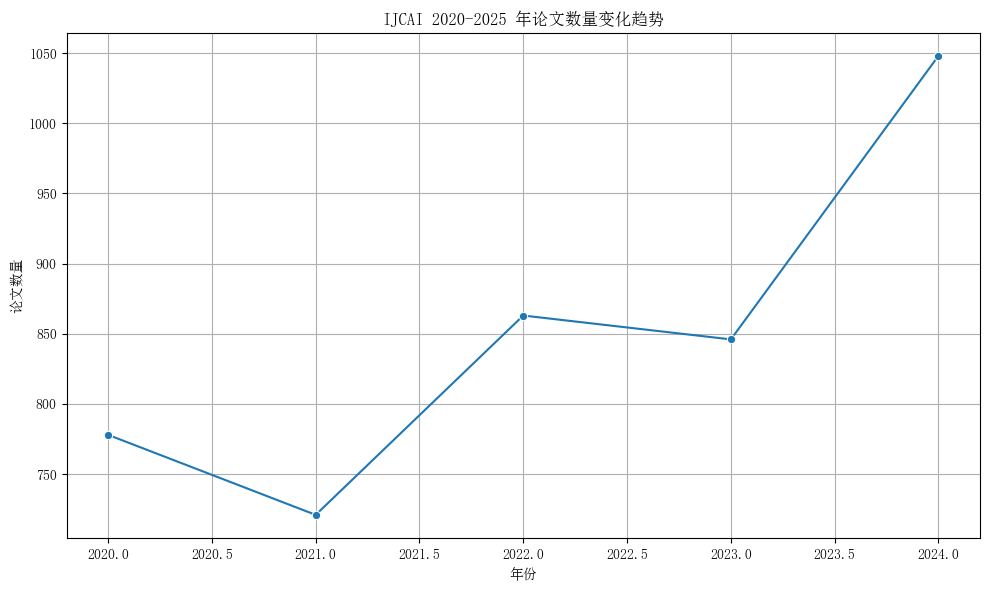

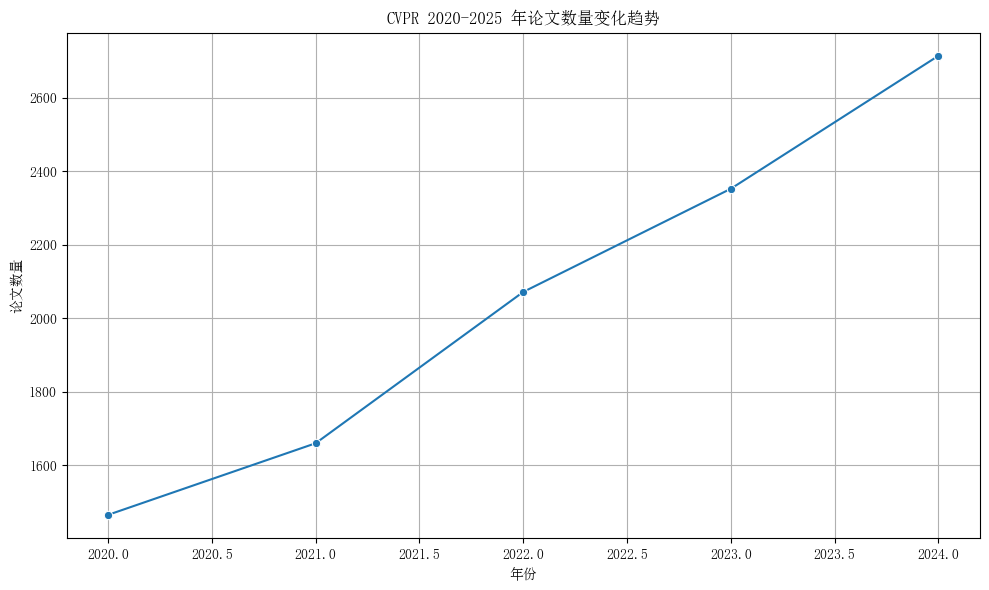

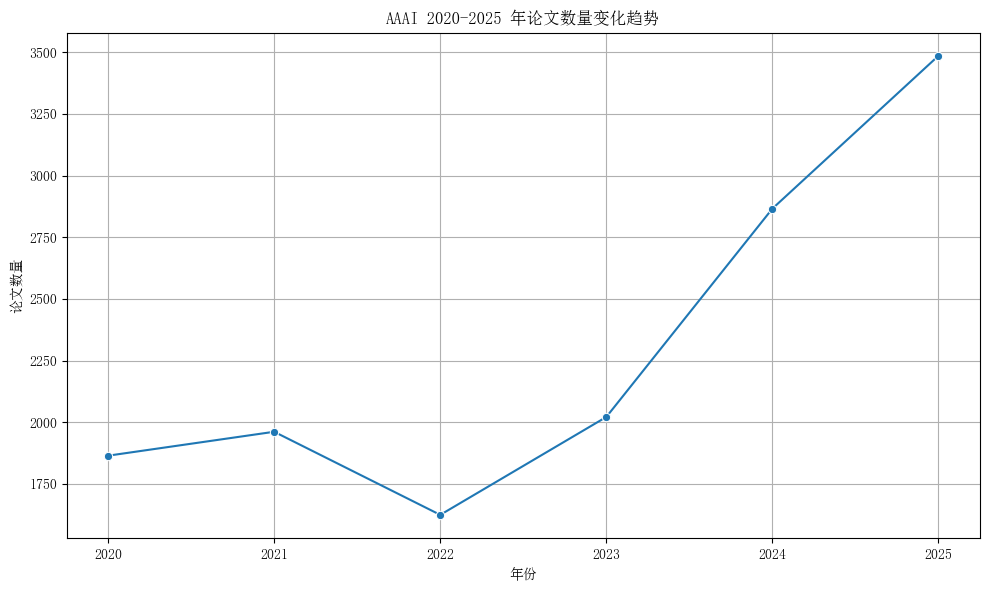

In [24]:
plot_year_trend_from_csv("ijcai_papers_2020_2025.csv",chart_title="IJCAI 2020-2025 年论文数量变化趋势")
plot_year_trend_from_csv("cvpr_papers_2020_2025.csv",chart_title="CVPR 2020-2025 年论文数量变化趋势")
plot_year_trend_from_csv("aaai_papers_2020_2025.csv",chart_title="AAAI 2020-2025 年论文数量变化趋势")

In [25]:
# 停用词集合（英文+自定义）
stop_words = set(ENGLISH_STOP_WORDS)
custom_stopwords = {
    'february'
}
stop_words = stop_words.union(custom_stopwords)

# 生成n元短语（ngram）
def generate_ngrams(words, n):
    iters = tee(words, n)
    for i, it in enumerate(iters):
        next(islice(it, i, i), None)
    return zip(*iters)

def generate_bigram_wordcloud(papers, start_year, end_year, title, top_k=100):
    # 过滤出目标年份范围内论文标题
    titles = [paper['title'] for paper in papers
              if paper.get('year') and str(paper['year']).isdigit()
              and start_year <= int(paper['year']) <= end_year]

    all_text = ' '.join(titles).lower()
    all_text = all_text.translate(str.maketrans('', '', string.punctuation))

    words = [w for w in all_text.split() if w not in stop_words and len(w) > 2]

    bigrams = [' '.join(bi) for bi in generate_ngrams(words, 2)]
    bigram_counts = Counter(bigrams)

    # 去除无效短语
    exclude_phrases = {"student abstract", "call for", "revised selected"}
    for phrase in exclude_phrases:
        if phrase in bigram_counts:
            del bigram_counts[phrase]

    print(f"Top 10 bigrams ({start_year}-{end_year}):")
    for phrase, freq in bigram_counts.most_common(10):
        print(f"{phrase}: {freq}")

    wc = WordCloud(width=1000, height=600, background_color='white', colormap='plasma')
    wc.generate_from_frequencies(dict(bigram_counts.most_common(top_k)))

    plt.figure(figsize=(12, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()
    plt.close()

In [26]:
# 定义要合并的CSV文件路径
csv_files = [
    "aaai_papers_2020_2025.csv",
    "cvpr_papers_2020_2025.csv",
    "ijcai_papers_2020_2025.csv"
]

# 读取并合并所有 CSV 文件
dfs = [pd.read_csv(f) for f in csv_files]
combined_df = pd.concat(dfs, ignore_index=True)
# 保存到新文件
combined_df.to_csv("all_conference_papers_2020_2025.csv", index=False, encoding='utf-8')
print("✅ 已保存为 all_conference_papers_2020_2025.csv")

✅ 已保存为 all_conference_papers_2020_2025.csv


In [27]:
def generate_wordcloud_from_csv(csv_path, start_year=2020, end_year=2025):
    # 确保 generate_bigram_wordcloud 函数已经定义

    df = pd.read_csv(csv_path)
    papers = df.to_dict(orient='records')
    
    # 生成词云
    generate_bigram_wordcloud(
        papers, 
        start_year=start_year, 
        end_year=end_year, 
        title=f'{start_year}-{end_year} 高频双词词云'
    )

Top 10 bigrams (2020-2022):
neural networks: 367
object detection: 326
reinforcement learning: 290
semantic segmentation: 194
representation learning: 179
domain adaptation: 157
neural network: 148
graph neural: 137
pose estimation: 136
point cloud: 124


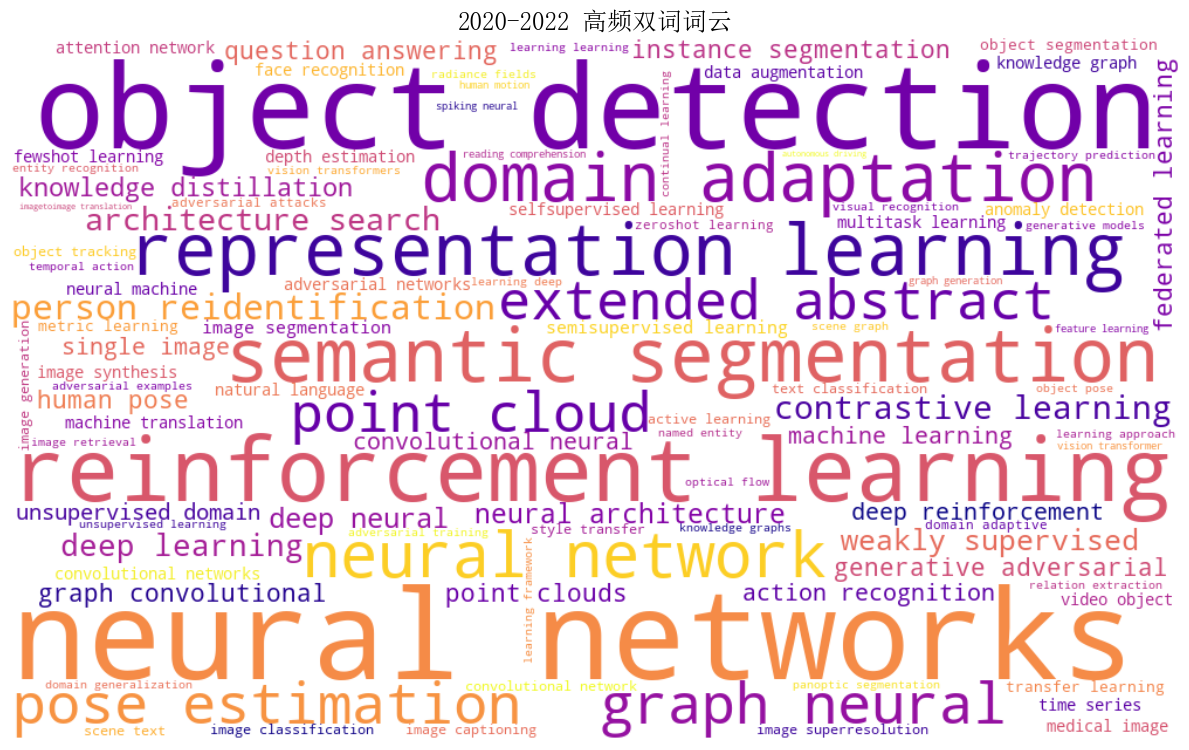

Top 10 bigrams (2023-2025):
reinforcement learning: 363
language models: 336
large language: 325
object detection: 323
diffusion models: 273
neural networks: 269
semantic segmentation: 210
contrastive learning: 208
point cloud: 206
federated learning: 196


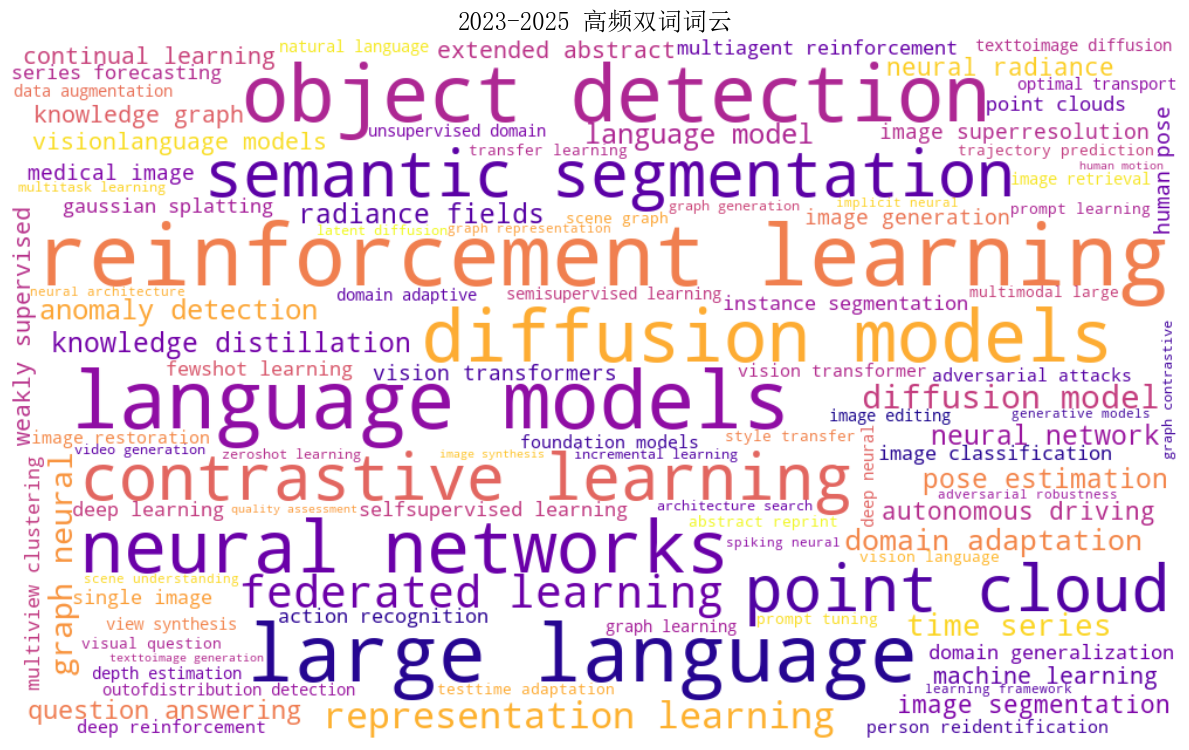

In [28]:
generate_wordcloud_from_csv('all_conference_papers_2020_2025.csv', start_year=2020, end_year=2022)
generate_wordcloud_from_csv('all_conference_papers_2020_2025.csv', start_year=2023, end_year=2025)

In [29]:
def predict_and_plot_by_year(csv_path, title="会议论文数量趋势（按年份）"):
    df = pd.read_csv(csv_path)

    # 仅保留有效年份
    df = df[df['year'].apply(lambda x: str(x).isdigit())]
    df['year'] = df['year'].astype(int)

    # 统计每年论文数量
    year_counts = df['year'].value_counts().sort_index()
    years = list(year_counts.index)
    counts = list(year_counts.values)

    # 训练线性回归模型
    X = np.array(years).reshape(-1, 1)
    y = np.array(counts)
    model = LinearRegression()
    model.fit(X, y)

    # 预测下一年
    next_year = max(years) + 1
    pred = model.predict([[next_year]])[0]

    print("📘 预测结果：")
    print(f"预测 {next_year} 年论文数量：{pred:.2f} 篇")

    # 绘图
    plt.figure(figsize=(10, 6))
    plt.scatter(years, counts, color='blue', label='实际论文数量')
    plt.plot(years, model.predict(X), color='green', linestyle='--', label='线性拟合')
    plt.scatter([next_year], [pred], color='red', label=f'预测 {next_year}')
    plt.xlabel("年份")
    plt.ylabel("论文数量")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()
    plt.close()
    return next_year, pred

📘 预测结果：
预测 2025 年论文数量：1050.70 篇


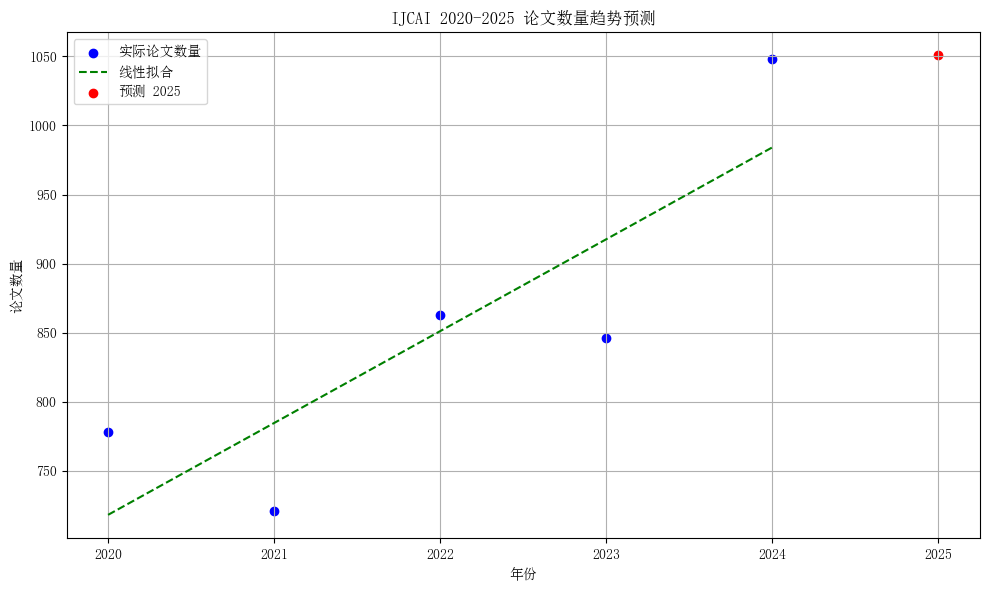

(2025, np.float64(1050.7000000000116))

In [33]:
predict_and_plot_by_year("ijcai_papers_2020_2025.csv", title="IJCAI 2020-2025 论文数量趋势预测")

📘 预测结果：
预测 2025 年论文数量：3010.90 篇


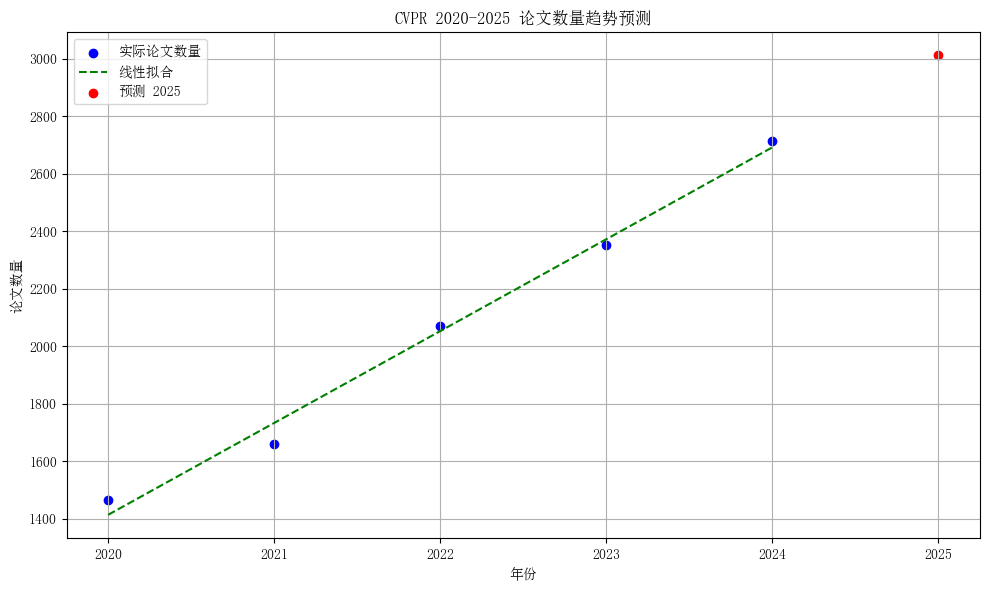

(2025, np.float64(3010.9000000000233))

In [34]:
predict_and_plot_by_year("cvpr_papers_2020_2025.csv", title="CVPR 2020-2025 论文数量趋势预测")

📘 预测结果：
预测 2026 年论文数量：3425.87 篇


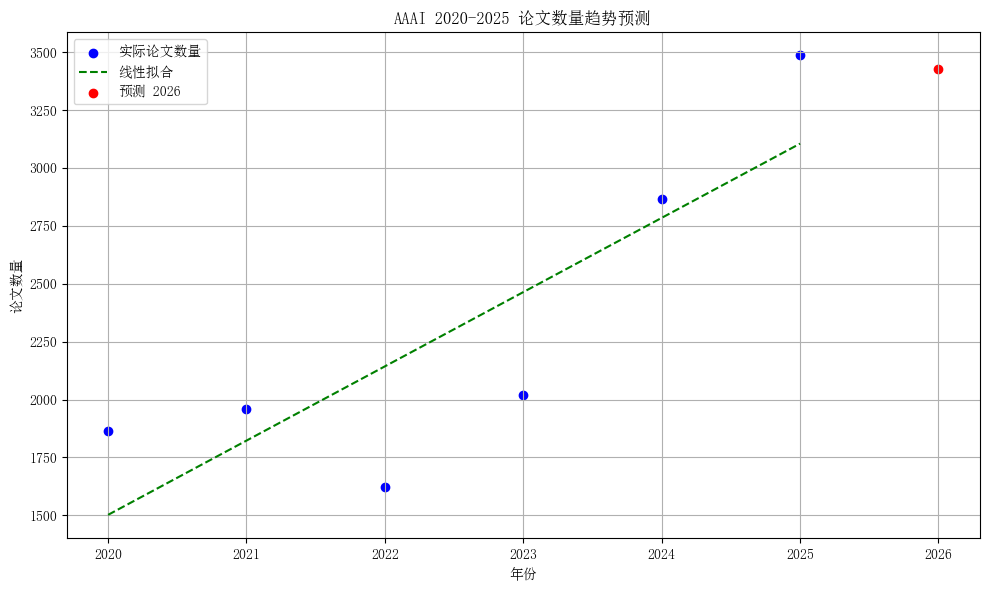

(2026, np.float64(3425.8666666666977))

In [36]:
predict_and_plot_by_year("aaai_papers_2020_2025.csv", title="AAAI 2020-2025 论文数量趋势预测")